# Исследование работы интернет-магазина A/B тестированием

## Краткое описание проекта

Имеется крупный интернет-магазин. Необходимо проанализировать (приоритезировать) ранее подготовленный список гипотез для увеличения выручки, а после этого запустить A/B-тесты и проанализировать результаты. 

### Описание файлов
Файл со списоком гипотез
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале (чем больше значение Efforts, тем дороже проверка гипотезы).

Файл со списоком заказов
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл со списоком визитом
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
import pandas as pd                                             # Импортируем библиотеки
import seaborn as sns                                           
import math
import matplotlib.pyplot as plt                                
from scipy import stats as st
import numpy as np

In [2]:
display(pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv',nrows = 5).head())         # Выведем на экран первые 5 строк 
display(pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv',nrows = 5).head())       
display(pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv',nrows = 5).head()) 

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Поcледовательно проверив все файлы, приходим к выводу, что все файлы корректно считываются, коррекция разделителя столбцов не требуется. Также необходимо отметить о несоответствии названий столбцов змеиному регистру первого и второго файла.

In [3]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')                           # Считаем файлы
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')              
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')  
list_table = [hypothesis, orders, visitors] # Создадим список датафреймов (согл. документации):

In [4]:
pd.set_option("display.max_colwidth", 100) #расширит ячейки до 100 символов в строке

In [5]:
for i in list_table:                                                    # Создадим цикл, который пройдет по всему списку
    display(i.head())                                                   # Выведем по 5 строк каждого
    i.info()                                                            # Выведем общую информацию
    print('    Дубликатов, шт:',i.duplicated().sum())                   # Выведем кол-во дубликатов
    print('    Пропусков по столбцам:')
    display(i.isna().sum())                                             # подсчёт пропусков
    #print('    Вывод статистической информации:')
    #round(visits.describe(),2)                                         # Выведем на экран статистическую информацию
    print()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
    Дубликатов, шт: 0
    Пропусков по столбцам:


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
    Дубликатов, шт: 0
    Пропусков по столбцам:


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
    Дубликатов, шт: 0
    Пропусков по столбцам:


date        0
group       0
visitors    0
dtype: int64

По данным информации, отображенной на экране в предыдущих двух ячейках, можно сделать план предобработки данных:

### Обзор проблем с датафреймами (план предобработки): 
<a class="anchor" id="plan"></a>
* hypothesis
    * названия столбцов привести к змеиному регистру
* orders
    * названия столбцов привести к змеиному регистру
    * столбцу 'date' изменить тип на временной.
* visitors
    * столбцу 'date' изменить тип на временной.


## Предобработка

### Изменение типов данных

In [7]:
print('До:',hypothesis.columns)
hypothesis.columns = hypothesis.columns.str.lower()                    # Названия в нижний регистр
print('После:',hypothesis.columns)
print()

orders = orders.rename(columns={'transactionId':'transaction_id','visitorId':'visitor_id'})
print('Итого:',orders.columns)
print()

orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')     # Было 2019-08-15
print('Тип:',orders['date'].dtype)                                     # Проверим

visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d') # Было 2019-08-01
print('Тип:',visitors['date'].dtype)                                   # Проверим


До: Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')
После: Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Итого: Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Тип: datetime64[ns]
Тип: datetime64[ns]


### Проверка на неявные дубликаты 
Проверим на неявные дубликаты критически важные данные - столбцы с группами.

In [8]:
# При помощи метода .value_counts() возвратим перечень уникальных значений и их кол-во
for i in [orders['group'],visitors['group']]:
    display(i.value_counts())

B    640
A    557
Name: group, dtype: int64

A    31
B    31
Name: group, dtype: int64

Промежуточный вывод: предобработка завершена успешно.
### Итоговые датафреймы для работы
Для дальнейшего удобства ещё раз выведем на экран по пять первых строк датафреймов:

In [9]:
display(hypothesis.head(10))
#hypothesis.info()

display(orders.head(5))
#orders.info()

display(visitors.head(5))
#visitors.info()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Приоритезация гипотез
Дополним файл с перечнем гипотез столбцами с оценками "ICE SCORE" и "RICE SCORE" и выведем перечень гипотез на экран:

In [10]:
hypothesis['ice'] = round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'],2)
hypothesis = hypothesis.sort_values(by='ice',ascending=False)
display(hypothesis.head(10))
hypothesis['rice'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis = hypothesis.sort_values(by='rice',ascending=False)
display(hypothesis.head(10))

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Промежуточный вывод: таблицы с оценками "ICE" и "RICE" построены. При сортировке по оценке "ICE" в ТОП-3 попадают гипотезы № 8, 0, 7, а по оценке "RICE" в ТОП-3 попадают гипотезы № 7, 2, 0. Основное различие между показателями оценки в использовании множителя "Reach" - предполагаемом количестве пользователей, которых затронут описываемые нововведения. Для полноценной приоритезации гипотез вариант "RICH" является предпочтительным, так как корректирует деятельность в направлении, где имеется больший охват аудитории.


## Анализ A/B теста
### Знакомство с данными

Перед началом работы по анализу А/В теста познакомимся с данными:
* определим, сведения о каких группах содержатся в имеющихся данных:

In [11]:
print('orders[group]:',orders['group'].unique())
print('visitors[group]:',visitors['group'].unique())

orders[group]: ['B' 'A']
visitors[group]: ['A' 'B']


Промежуточный вывод: групп всего две - А и В.
Определим, сведения о каком временном диапазоне содержатся в имеющихся данных:    

In [13]:
print('orders[date]:',orders['date'].min(),' - ',orders['date'].max())
print('visitors[date]:',visitors['date'].min(),' - ',visitors['date'].max())

orders[date]: 2019-08-01 00:00:00  -  2019-08-31 00:00:00
visitors[date]: 2019-08-01 00:00:00  -  2019-08-31 00:00:00


Промежуточный вывод: в обоих файлах зафиксированы события с 01 по 31 августа 2019 года. 
Определим, есть ли пользователи, которые зачислены в обе группы А и В:

In [14]:
user_A = orders[orders['group']=='A'][['visitor_id','group']].drop_duplicates().set_index('visitor_id')
user_A.columns=['group_A']
user_B = orders[orders['group']=='B'][['visitor_id','group']].drop_duplicates().set_index('visitor_id')
user_B.columns=['group_B']
coincidence = user_A.join(user_B).dropna(subset=['group_A','group_B'])
print('Количество пользователей, которые присутствуют одновременно в группах А и В, чел:',len(coincidence))

Количество пользователей, которые присутствуют одновременно в группах А и В, чел: 58


Удалим проблемных пользователей из датафреймов:

In [15]:
peremennaya_coincidence = coincidence.reset_index()['visitor_id']
orders = orders.query('visitor_id not in @peremennaya_coincidence')

user_A = orders[orders['group']=='A'][['visitor_id','group']].drop_duplicates().set_index('visitor_id')
user_A.columns=['group_A']
user_B = orders[orders['group']=='B'][['visitor_id','group']].drop_duplicates().set_index('visitor_id')
user_B.columns=['group_B']
coincidence = user_A.join(user_B).dropna(subset=['group_A','group_B'])
print('Количество пользователей, которые присутствуют одновременно в группах А и В, чел:',len(coincidence))

Количество пользователей, которые присутствуют одновременно в группах А и В, чел: 0


### Определение 95 и 99-й перцентили 
#### Количество заказов на пользователя

In [16]:
count_order = orders.groupby('visitor_id').agg({'revenue':'count'})
count_order = count_order.reset_index().drop('visitor_id',axis=1)          # Добавлено

count_order.columns =['count']

np.percentile(count_order['count'], [95, 99])

array([1., 2.])

Промежуточный вывод: не более 5% пользователей делают больше 1 заказа, и не более 1% больше 2 заказов.

Границу для определения аномальных пользователей по количеству заказов можно принять на уровне 95 перцентили (2 и более заказов.) 

#### Стоимость заказов

In [17]:
np.percentile(orders['revenue'], [95, 96, 97, 98, 99])

array([26785., 30649., 34792., 42353., 53904.])

Промежуточный вывод: не более 5% заказов имеют стоимость более 26785 единиц, и не более 1% заказов имеет стоимость более 53904 единиц.

Границу для определения аномальных пользователей по высокой стоимости можно принять на уровне 95 перцентили (26785).

### Форматирование данных
#### Кумулятивные данные

In [18]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 
#display(datesGroups.head(5))

# Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий.
# Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups,
# а группа теста равна группе из datesGroups:

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
#display(ordersAggregated.head(5))

# Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина: 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 
#display(visitorsAggregated.head(5))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'revenue', 'visitors']
display(cumulativeData.head(5)) 

,date,group,orders,revenue,visitors
0,2019-08-01,A,19,142779,719
1,2019-08-01,B,17,59758,713
2,2019-08-02,A,36,234381,1338
3,2019-08-02,B,39,221801,1294
4,2019-08-03,A,60,346854,1845


####  Очистка (фильтрация) данных

In [19]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 


usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(count_order['count'], 95)]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(count_order['count'], 95)]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
display(abnormalUsers.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64

86

Итого получилось 86 аномальных пользователей. 

#### Кумулятивные данные c учетом фильтрации

In [21]:
abnormalUsers_ = abnormalUsers.reset_index()
peremennaya = abnormalUsers_['visitor_id']
orders_filter = orders.query('visitor_id not in @peremennaya')

# Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий.
# Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups,
# а группа теста равна группе из datesGroups:

ordersAggregated_filter = datesGroups.apply(lambda x: orders_filter[np.logical_and(orders_filter['date'] <= x['date'], 
                                             orders_filter['group'] == x['group'])]
                                            .agg({'date' : 'max', 'group' : 'max', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
display(ordersAggregated.head(5))

# Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина: 
#visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 
#display(visitorsAggregated.head(5))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData_filter = ordersAggregated_filter.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData_filter.columns = ['date', 'group', 'orders', 'revenue', 'visitors']
display(cumulativeData_filter.head(5))                                                    
                                                             

,date,group,visitor_id,revenue
55,2019-08-01,A,19,142779
66,2019-08-01,B,17,59758
175,2019-08-02,A,36,234381
173,2019-08-02,B,39,221801
291,2019-08-03,A,60,346854


,date,group,orders,revenue,visitors
0,2019-08-01,A,13,31869,719
1,2019-08-01,B,17,59758,713
2,2019-08-02,A,28,78352,1338
3,2019-08-02,B,35,144622,1294
4,2019-08-03,A,52,190825,1845


### Построение графиков
#### Кумулятивная выручка по группам

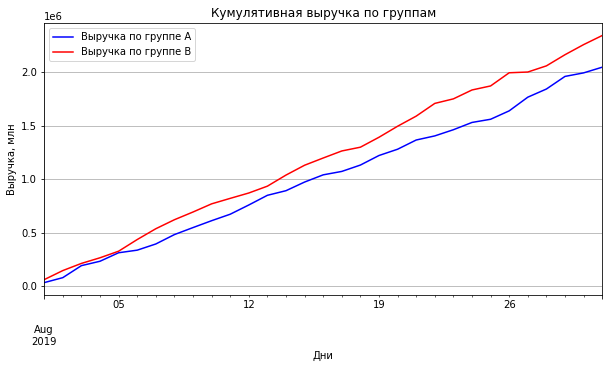

In [22]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням по группам
cumulativeRevenueA_filter = cumulativeData_filter[cumulativeData_filter['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB_filter = cumulativeData_filter[cumulativeData_filter['group']=='B'][['date','revenue', 'orders']]

ax=cumulativeRevenueA_filter.plot(x='date',y='revenue',label='Выручка по группе A',color='b')
cumulativeRevenueB_filter.plot(x='date',y='revenue',label='Выручка по группе B',color='r',ax=ax, grid=True,figsize=(10,5))
plt.title("Кумулятивная выручка по группам")
plt.xlabel("Дни")
plt.ylabel("Выручка, млн")  
plt.show()

Промежуточный вывод: на графике по очищенным данным от аномальных пользователей наблюдается стабильное превышение кумулятивной выручки по группе B.

#### Кумулятивное количество заказов по группам

In [25]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

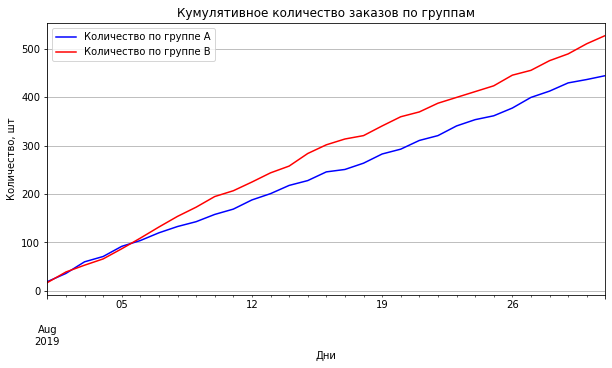

In [24]:
ax=cumulativeRevenueA.plot(x='date',y='orders',label='Количество по группе A',color='b')
cumulativeRevenueB.plot(x='date',y='orders',label='Количество по группе B',color='r',ax=ax, grid=True,figsize=(10,5))
plt.title("Кумулятивное количество заказов по группам")
plt.xlabel("Дни")
plt.ylabel("Количество, шт")  
plt.show()

Промежуточный вывод: с пятого августа линии разделяются, после чего количество заказов от пользователей группы В становится значительно больше количества заказов от пользователей группы А.

####  Кумулятивный средний чек по группам

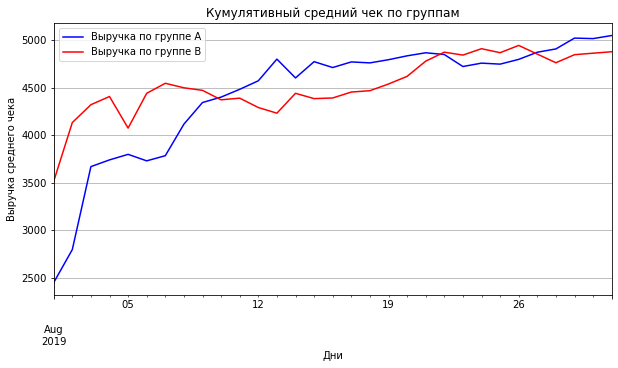

In [26]:
cumulativeRevenueA_filter['k_A'] = cumulativeRevenueA_filter['revenue']/cumulativeRevenueA_filter['orders']
cumulativeRevenueB_filter['k_B'] = cumulativeRevenueB_filter['revenue']/cumulativeRevenueB_filter['orders']
ax=cumulativeRevenueA_filter.plot(x='date',y='k_A',label='Выручка по группе A',color='b')
cumulativeRevenueB_filter.plot(x='date',y='k_B',label='Выручка по группе B',color='r',ax=ax, grid=True,figsize=(10,5))
plt.title("Кумулятивный средний чек по группам")
plt.xlabel("Дни")
plt.ylabel("Выручка среднего чека")  
plt.show()

Промежуточный вывод: по графику с учетом очистки данных от аномальных пользователей можно сказать, что нет оснований считать о наличии существенной разницы среднего чека между группами.

#### Относительное изменение кумулятивного среднего чека группы В к группе А

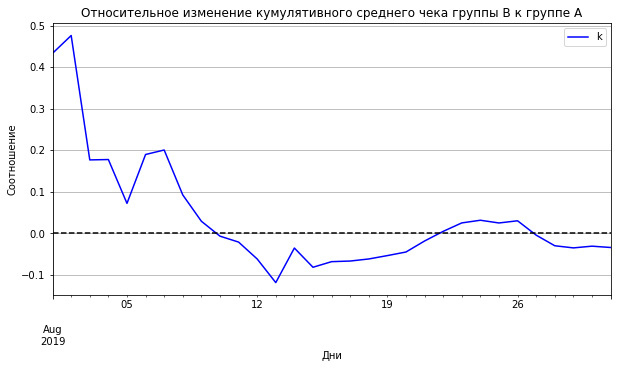

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue_filter = cumulativeRevenueA_filter.merge(cumulativeRevenueB_filter, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue_filter['k'] = mergedCumulativeRevenue_filter['k_B']/mergedCumulativeRevenue_filter['k_A'] - 1
mergedCumulativeRevenue_filter.plot(x='date',y='k',color='b',grid=True,figsize=(10,5))
plt.title("Относительное изменение кумулятивного среднего чека группы В к группе А")
plt.xlabel("Дни")
plt.ylabel("Соотношение")
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

Промежуточный вывод: по графику после фильтрации данных от аномальных пользователей можно сказать, что разница среднего чека стремится к нулю.

#### Кумулятивная конверсия по группам

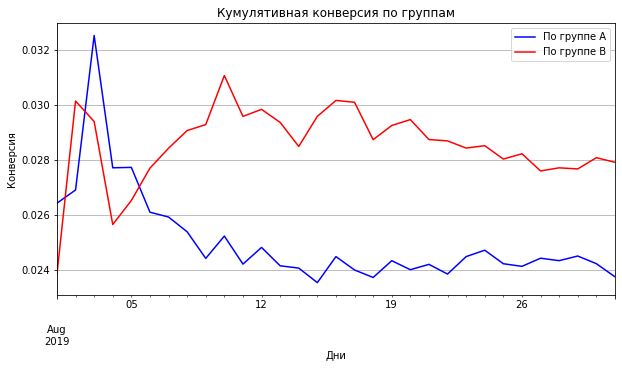

In [29]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
ax=cumulativeDataA.plot(x='date',y='conversion',label='По группе A',color='b')
cumulativeDataB.plot(x='date',y='conversion',label='По группе B',color='r',ax=ax, grid=True,figsize=(10,5))
plt.title("Кумулятивная конверсия по группам")
plt.xlabel("Дни")
plt.ylabel("Конверсия")  
plt.show()

Промежуточный вывод: В первые дни, до 5 августа конверсия по обоим группам похожая. 5 августа произошло какое-то событие, после чего кумулятивная конверсия по группе А зафиксировалась на сравнительно низком уровне около 0,024, а кумулятивная конверсия по группе В достигла пика 10 августа в размере 0,031, после чего стала снижаться, в конце наблюдения её значение составило 0,028. 

#### Относительное изменение кумулятивной конверсии группы В к группе А.

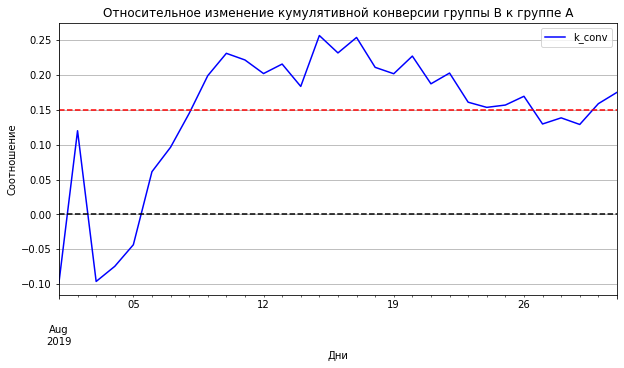

In [31]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

mergedCumulativeConversions['k_conv'] = mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1
mergedCumulativeConversions.plot(x='date',y='k_conv',color='b',grid=True,figsize=(10,5))
plt.title("Относительное изменение кумулятивной конверсии группы В к группе А")
plt.xlabel("Дни")
plt.ylabel("Соотношение")
plt.axhline(y=0, color='black', linestyle='--') 
plt.axhline(y=0.15, color='red', linestyle='--') 
plt.show()

Промежуточный вывод: после 5 августа соотношение кумулятивной конверсии группы В к группе А больше нуля, то есть кумулятивная конверсия по группе В больше аналогичного значения по группе А.

#### Точечный количества заказов по пользователям

Для построения точечного графика сгруппируем заказы по пользователям:

In [32]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby(
    'visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']
print(ordersByUsers.sort_values(by='orders',ascending=False).head(10))

        user_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


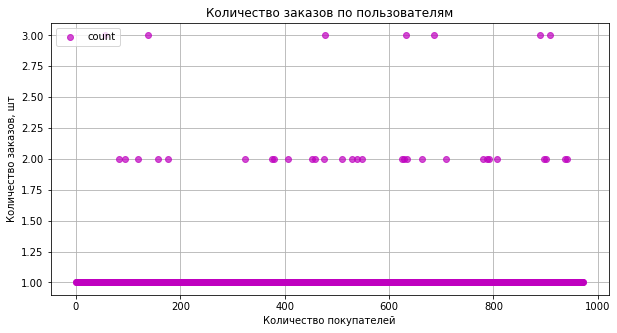

In [33]:
count_order.plot(y='count',style='o',color='m',grid=True,figsize=(10,5),alpha=0.7)
plt.title("Количество заказов по пользователям")
plt.xlabel("Количество покупателей")
plt.ylabel("Количество заказов, шт")
plt.show()

Промежуточный вывод: большинство покупателей делают по одному заказу, незначительная часть - по два заказа и более.

#### Точечный график стоимости заказов

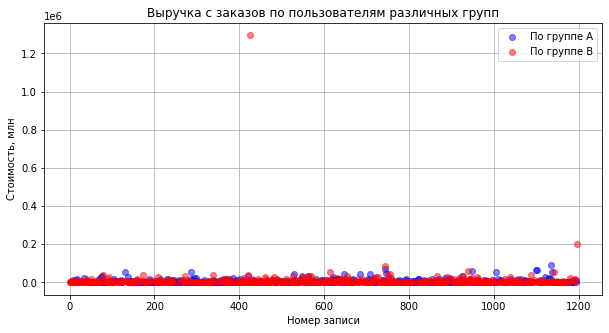

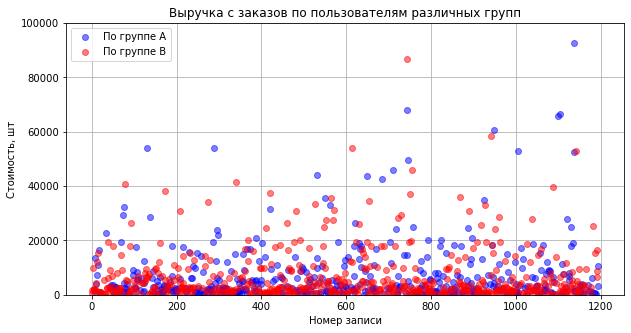

In [34]:
ax= orders[orders['group']=='A'].plot(y='revenue',style='o',color='b',label='По группе A',alpha=0.5)
orders[orders['group']=='B'].plot(y='revenue',style='o',ax=ax,color='r',label='По группе B',grid=True,figsize=(10,5),alpha=0.5)
plt.title("Выручка с заказов по пользователям различных групп")
plt.xlabel("Номер записи")
plt.ylabel("Стоимость, млн")
plt.show()

ax= orders[orders['group']=='A'].plot(y='revenue',style='o',color='b',label='По группе A',alpha=0.5)
orders[orders['group']=='B'].plot(y='revenue',style='o',ax=ax,color='r',label='По группе B',grid=True,ylim=(0,100000),figsize=(10,5),alpha=0.5)
plt.title("Выручка с заказов по пользователям различных групп")
plt.xlabel("Номер записи")
plt.ylabel("Стоимость, шт")
plt.show()

Промежуточный вывод: на первом графике видны заказы с выручкой в размере 200 000 и более 1,2 млн, являющиеся выбросами. 

С ограничением по оси y видно, что большинство заказов имеет выручку до 10 000 единиц, небольшое количество от 20 до 50 тысяч, стоимость более 60 000 единичны и их можно считатать выбросами.

### Определение статистической значимости 
#### Различия в конверсии между группами по "сырым" данным.

Сформируем нулевую гипотезу: статистически значимых различий в конверсии между группами по "сырым" данным между группами нет (при p-value >= 0.05). 

Альтернативная гипотеза: статистически значимые различия в конверсии между группами по "сырым" данным есть (при p-value <0.05).
Проверим это:

In [35]:
# Создадим ordersA и ordersB  с данными о пользователях и количестве совершенных покупок
ordersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersA.columns = ['visitor_id', 'orders']

ordersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersB.columns = ['visitor_id', 'orders']

# Добавляем записи с нулевым заказом в кол-ве, соответсвующем разнице между общим кол-вом посетителей и покупателей
groupA = pd.concat([ordersA['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].
    sum() - len(ordersA['orders'])), name='orders')],axis=0)
groupB = pd.concat([ordersB['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].
    sum() - len(ordersB['orders'])), name='orders')],axis=0)  

# передаем массивы в методы 
print("p-value по равенству конверсии: {0:.5f}".format(st.mannwhitneyu(groupA, groupB)[1]))
print("Относительное превышение средней конверсии по группе В: {0:.3f}".format(groupB.mean()/groupA.mean()-1))

p-value по равенству конверсии: 0.01102
Относительное превышение средней конверсии по группе В: 0.160


P-value по равенству конверсии меньше 0.05. Значит, отвергаем нулевую гипотезу о том, что статически значимых различий в конверсии между группами нет.

Cредняя конверсия группы B выше (на 16 %) конверсии по группе A.

####  Различия в конверсии между группами по "очищенным" данным.
Сформируем нулевую гипотезу: статистически значимых различий в конверсии между группами по "сырым" данным между группами нет (при p-value >= 0.05). Альтернативная гипотеза: статистически значимые различия в конверсии между группами по "сырым" данным есть (при p-value <0.05). 

In [39]:
# Создадим ordersA и ordersB  с данными о пользователях и количестве совершенных покупок
ordersA_filter = orders_filter[orders_filter['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersA_filter.columns = ['visitor_id', 'orders']

ordersB_filter = orders_filter[orders_filter['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersB_filter.columns = ['visitor_id', 'orders']

# Добавляем записи с нулевым заказом в кол-ве, соответсвующем разнице между общим кол-вом посетителей и покупателей
groupA_filter= pd.concat([ordersA_filter['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].
    sum() - len(ordersA_filter['orders'])), name='orders')],axis=0)
groupB_filter = pd.concat([ordersB_filter['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].
    sum() - len(ordersB_filter['orders'])), name='orders')],axis=0)  

# передаем массивы в методы 
print("p-value по равенству конверсии: {0:.5f}".format(st.mannwhitneyu(groupA_filter, groupB_filter)[1]))
print("Относительное превышение средней конверсии по группе В: {0:.3f}".format(groupB_filter.mean()/groupA_filter.mean()-1))

p-value по равенству конверсии: 0.01620
Относительное превышение средней конверсии по группе В: 0.173


P-value по равенству конверсии менее 0.05. Значит, отвергаем нулевую гипотезу о том, что статически значимых различий в конверсии между группами нет.

Cредняя конверсия группы B выше (на 17,3 %) конверсии по группе A.


#### Различия в среднем чеке заказа между группами по "сырым" данным.

Сформируем нулевую гипотезу: статистически значимых различий в среднем чеке заказа между группами нет. Альтернативная гипотеза: статистически значимые различия в среднем чеке заказа между группами есть.

In [40]:

print('P-value по равенству среднего чека: ','{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное превышение среднего чека группы В:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value по равенству среднего чека:  0.829
Относительное превышение среднего чека группы В: 0.287


P-value по равенству среднего чека значительно больше 0.05. Значит, нет причин отвергать нулевую гипотезу о том, что статически значимых различий в среднем чеке между группами нет.

Cредний чек группы B значительно выше (на 28.7%) среднего чека группы A, такая большая разница в средних чеках случайна.

#### Различия в среднем чеке заказа между группами по "очищенным" данным.
Сформируем нулевую гипотезу: статистически значимых различий в среднем чеке заказа между группами нет. Альтернативная гипотеза: статистически значимые различия в среднем чеке заказа между группами есть.

In [41]:
# результаты по среднему чеку

print('P-value по равенству среднего чека: ','{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное превышение среднего чека группы В:',"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value по равенству среднего чека:  0.727
Относительное превышение среднего чека группы В: -0.034


P-value по равенству среднего чека значительно больше 0.05. Значит, нет причин отвергать нулевую гипотезу и считать, что в среднем чеке нет различий.

Cредний чек группы B и A практически равны.
Вывод: после фильтрации данных от выборки сравнялись между собой.

## Выводы

По итогам анализа зафиксированы статистические значимые различия между группами А и В.

Установлено, что конверсия в группе В выше на 17,3%, при этом нет статистически значимых различий между группами по размеру среднего чека. 

Тест останавливаем. Фиксируем победу версии В.